In [1]:
import numpy as np
import pandas as pd
import os

from stable_baselines3 import DQN, PPO, A2C
from sb3_contrib import QRDQN
# from stable_baselines import DQN
# from stable_baselines3.common.env_checker import check_env

from utils import preprocessing
from utils.feature_enginner import FeatureEngineer
from utils.data_loader import DataLoader
from models.features_extractor import CustomCNN
from envs.trading_env import SimpleTradingEnv
from envs.base import BaseTradingEnv



Loading BokehJS ...

In [2]:
window_size = 20
fee = 0.000665

In [3]:
# from enum import Enum
# class Actions(Enum):
#     Sell = 0
#     Buy = 1
#     Hold = 2

In [4]:
class TradingEnv(BaseTradingEnv):
    def _calculate_reward(self):
        # reward = 0.0
        reward = self.position.profit_or_loss_pct - self.prev_profit_or_loss_pct
        if self.closed_trades.empty:
            return reward

        trade = self.closed_trades.iloc[-1, :]
        return reward if trade["ExitTime"] != self.current_datetime else trade["ReturnPct"]
    # def _calculate_reward(self):
    #     reward = (self.wallet.equity - self.prev_equity) / self.prev_equity
    #     return reward

In [5]:
# def preprocessing(candles):
#     df = pd.DataFrame()
#     price = candles["Close"]
#     df["diff_price_pct"] = price.pct_change(1)
#     df = df.fillna(0)
#     print(df.head())
#     return df

In [6]:
df = DataLoader.load_data("./data/3600/ethusd/2021-01-01.csv")
train_df = df[: len(df) // 2]
eval_df = df[len(df) // 2 :]

feature_enginner = FeatureEngineer([])
train_features = feature_enginner.preprocessing(train_df)
eval_features = feature_enginner.preprocessing(eval_df)
train_env = TradingEnv(train_df, train_features, window_size=window_size, fee=fee)
eval_env = TradingEnv(eval_df, eval_features, window_size=window_size, fee=fee)
# check_env(train_env)

In [8]:
# policy_kwargs = dict(
#     features_extractor_class=CustomCNN,
#     features_extractor_kwargs=dict(features_dim=32),
# )
# model = PPO("CnnPolicy", train_env, verbose=0, tensorboard_log="./logs", policy_kwargs=policy_kwargs)
# model = PPO("MlpPolicy", train_env, verbose=1, tensorboard_log="./logs")
model_class = DQN
model = model_class("MlpPolicy", train_env, tensorboard_log="./logs", target_update_interval=100, learning_starts=500, learning_rate=1e-3).learn(total_timesteps=30000, eval_env=eval_env, eval_freq=1000, n_eval_episodes=1)
model_name = model.__class__.__name__
# model.save(f"./results/{model_name}")
# del model

Eval num_timesteps=1000, episode_reward=-0.19 +/- 0.00
Episode length: 2141.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=0.77 +/- 0.00
Episode length: 2141.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-1.53 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=0.50 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-0.00 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=0.13 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-0.20 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=0.19 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=0.40 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-2.55 +/- 0.00
Episode length: 2141.00 +/- 0.00
Eval num_timesteps=11000, episode_reward=0.24 +/- 0.00
Episode length: 2141.00 +

In [9]:
# model = model_class.load(f"./results/{model_name}")
print(model)

In [10]:
from stable_baselines3.common.evaluation import evaluate_policy

In [12]:
mean_reward, std_reward = evaluate_policy(model, eval_env, return_episode_rewards=False, deterministic=True, n_eval_episodes=1)
print(mean_reward, std_reward)

0.20773032000579406 0.0


[-0.00066544  0.00477125 -0.00119281 ...  0.00168554 -0.02821916
 -0.20896523]


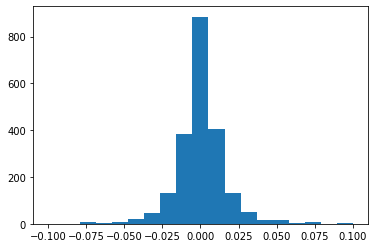

In [13]:
import matplotlib.pyplot as plt
def evaluate(model, env, render=True) -> np.ndarray:
    state = env.reset()
    done = False

    episode_rewards = []

    while not done:
        action, state = model.predict(state)
        state, reward, done, info = env.step(action)

        if render:
            env.render()

        episode_rewards.append(reward)

        if done:
            break

    return np.array(episode_rewards)


episode_rewards = evaluate(model, eval_env, render=False)
print(episode_rewards)
episode_rewards = episode_rewards[~(episode_rewards == 0)]
fig, axs = plt.subplots(1, 1)
bins = np.linspace(-0.1, 0.1, 20)
n, bins, patches = axs.hist(episode_rewards, bins=bins)

In [14]:
from utils import backtest

In [15]:
stats_train = backtest(model, train_env, plot=True, plot_filename=f"./results/BackTest-{model_name}-train")
stats_eval = backtest(model, eval_env, plot=True, plot_filename=f"./results/BackTest-{model_name}-eval")

stats = pd.DataFrame()
stats["train"] = stats_train
stats["eval"] = stats_eval
# stats = stats.drop(["Best Trade [%]", "Worst Trade [%]", "_strategy", "_equity_curve", "_trades"], axis=0)
stats

,train,eval
Start,2021-01-01 00:00:00,2021-04-01 00:00:00
End,2021-03-31 23:00:00,2021-06-30 00:00:00
Duration,89 days 23:00:00,90 days 00:00:00
Exposure Time [%],99.0278,99.0282
Equity Final [$],276579,686873
Equity Peak [$],1.02283e+06,1.0041e+06
Return [%],-72.3421,-31.3127
Buy & Hold Return [%],149.949,21.1915
Return (Ann.) [%],-99.4445,-77.5362
Volatility (Ann.) [%],94.3353,57.5754


In [16]:
stats.loc["_strategy", "train"].env.closed_trades

,Size,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime
0,-1354,738.078851,1101.7,-492343.035814,-0.492659,2021-01-01 20:00:00,2021-01-11 13:00:00
1,-456,1112.559655,1022.1,41249.602908,0.081308,2021-01-11 14:00:00,2021-01-11 16:00:00
2,512,1071.011749,1070.4,-313.215744,-0.000571,2021-01-11 17:00:00,2021-01-14 01:00:00
3,-511,1071.886721,1137.3,-33426.185569,-0.061026,2021-01-14 02:00:00,2021-01-16 04:00:00
4,-455,1131.846821,1304.0,-78329.696445,-0.152099,2021-01-16 05:00:00,2021-01-20 20:00:00
...,...,...,...,...,...,...,...
69,-188,1597.237130,1599.2,-369.019466,-0.001229,2021-03-25 23:00:00,2021-03-26 00:00:00
70,188,1596.460941,1612.3,2977.743092,0.009921,2021-03-26 01:00:00,2021-03-26 04:00:00
71,189,1606.067325,1627.5,4050.775575,0.013345,2021-03-26 05:00:00,2021-03-26 11:00:00
72,-190,1611.627555,1704.6,-17664.764645,-0.057689,2021-03-26 12:00:00,2021-03-29 17:00:00


In [17]:
stats.loc["_trades", "train"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-1354,20,253,738.078851,1101.7,-492343.035814,-0.492659,2021-01-01 20:00:00,2021-01-11 13:00:00,9 days 17:00:00
1,-456,254,256,1112.559655,1022.1,41249.602908,0.081308,2021-01-11 14:00:00,2021-01-11 16:00:00,0 days 02:00:00
2,512,257,313,1071.011749,1070.4,-313.215744,-0.000571,2021-01-11 17:00:00,2021-01-14 01:00:00,2 days 08:00:00
3,-511,314,364,1071.886721,1137.3,-33426.185569,-0.061026,2021-01-14 02:00:00,2021-01-16 04:00:00,2 days 02:00:00
4,-455,365,476,1131.846821,1304.0,-78329.696445,-0.152099,2021-01-16 05:00:00,2021-01-20 20:00:00,4 days 15:00:00
...,...,...,...,...,...,...,...,...,...,...
69,-188,2015,2016,1597.237130,1599.2,-369.019466,-0.001229,2021-03-25 23:00:00,2021-03-26 00:00:00,0 days 01:00:00
70,188,2017,2020,1596.460941,1612.3,2977.743092,0.009921,2021-03-26 01:00:00,2021-03-26 04:00:00,0 days 03:00:00
71,189,2021,2027,1606.067325,1627.5,4050.775575,0.013345,2021-03-26 05:00:00,2021-03-26 11:00:00,0 days 06:00:00
72,-190,2028,2105,1611.627555,1704.6,-17664.764645,-0.057689,2021-03-26 12:00:00,2021-03-29 17:00:00,3 days 05:00:00
